# Introduction à la Science de Données
# TP2 -  Classification par les $k$ plus proches voisins


La documentation Scikit-learn sur les $k$ plus proches voisins se trouve ici: http://scikit-learn.org/stable/modules/neighbors.html


## Données *digits*
Dans la première partie de ce TP, nous allons utiliser des données déjà présentes dans scikit-learn, à l'image des données Iris du premier TP.

Ces données sont très connues en apprentissage, sous le noms de MNIST. Elles sont composées d'images de chiffres manuscrits à une résolution de 8*8. En scikit-learn, elles se nomment digits : 

In [1]:
import numpy as np # importation du package numérique
from sklearn.datasets import load_digits

digitsData=load_digits() # jeu de données digits
X=digitsData.data # les exemples, un array numpy, chaque élément est aussi un array
y=digitsData.target # les classes

On peut regarder quelques informations :

In [2]:
print(X.dtype, X.shape)
print(y.dtype, y.shape)

(dtype('float64'), (1797, 64))
(dtype('int64'), (1797,))


Chaque donnée est donc une image de 8 pixels par 8 pixels, en niveau de gris (256 nuances possibles), stockée sous la forme d'un vecteur de dimension 64 comme une ligne de la matrice $X$ (il y a 1797 images) et avec la valeur de la classe associée stockée dans un vecteur $y$ à part (comme pour Iris). Mais on peut quand même regarder l'image initiale :




("Le vecteur de l'image d'indice 42 : ", array([ 0.,  0.,  0.,  0., 12.,  5.,  0.,  0.,  0.,  0.,  0.,  2., 16.,
       12.,  0.,  0.,  0.,  0.,  1., 12., 16., 11.,  0.,  0.,  0.,  2.,
       12., 16., 16., 10.,  0.,  0.,  0.,  6., 11.,  5., 15.,  6.,  0.,
        0.,  0.,  0.,  0.,  1., 16.,  9.,  0.,  0.,  0.,  0.,  0.,  2.,
       16., 11.,  0.,  0.,  0.,  0.,  0.,  3., 16.,  8.,  0.,  0.]))
[[ 0.  0.  0.  0. 12.  5.  0.  0.]
 [ 0.  0.  0.  2. 16. 12.  0.  0.]
 [ 0.  0.  1. 12. 16. 11.  0.  0.]
 [ 0.  2. 12. 16. 16. 10.  0.  0.]
 [ 0.  6. 11.  5. 15.  6.  0.  0.]
 [ 0.  0.  0.  1. 16.  9.  0.  0.]
 [ 0.  0.  0.  2. 16. 11.  0.  0.]
 [ 0.  0.  0.  3. 16.  8.  0.  0.]]


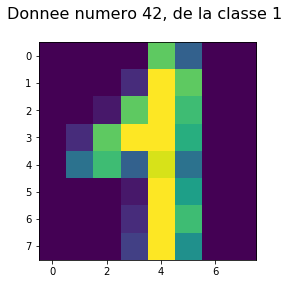

In [3]:
import matplotlib.pyplot as plt  # le package de visualisation
# la ligne spéciale pour que le notebook affiche comme il faut :
%matplotlib inline  

donnee = X[42,:] # on récupère une ligne, donc une donnée
classe = y[42]   # et sa classe
print("Le vecteur de l'image d'indice 42 : ", donnee)

image = np.reshape(donnee,(8,8)) # on met les 8 morceaux de taille 8 du vecteur les uns en dessous des autres
print(image) # on affiche la matrice de pixels
plt.imshow(image) # on affiche l'image qui lui correspond
plt.title('Donnee numero 42, de la classe %i \n' % classe, fontsize = 16) # avec un titre
plt.show()

On peut faire des affichages plus intéressant, exemple sur les 5 premières données :

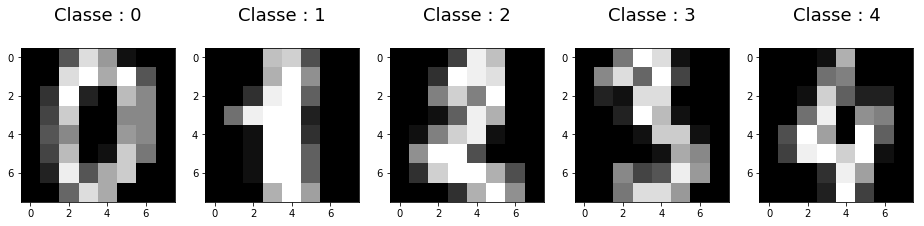

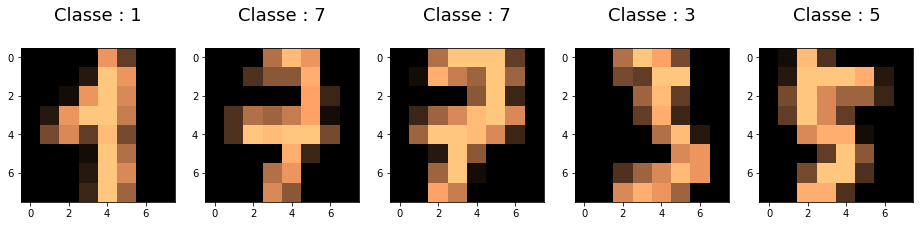

In [4]:
plt.figure(figsize=(16,4))
for index, (image, classe) in enumerate(zip(X[0:5], y[0:5])): # zip forme des couples (X,Y)
    plt.subplot(1, 5, index + 1) #1 et 5 = taille image, index+1 est l'endroit ou il est affiché
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title('Classe : %i\n' % classe, fontsize = 18)
plt.show()
    
plt.figure(figsize=(16,4))
for index, (image, classe) in enumerate(zip(X[42:47], y[42:47])):
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap="copper")
    plt.title('Classe : %i\n' % classe, fontsize = 18)  
plt.show()

## Création et entraînement d'un classifieur

Notre objectif est maintenant d'apprendre, sur la base d'un échantillon d'images "chiffres", un classifieur capable de prédire le chiffre qui correspond à une nouvelle image. Nous allons utiliser la méthode des $k$-plus proches voisins pour cet apprentissage. Elle est implémentée dans un package appelé *neighbors*. Examinons la série d'instructions suivante:

In [5]:
from sklearn import neighbors as nn # importation du package d'algorithmes travaillant sur les points voisins
help(nn.KNeighborsClassifier) # que fait cette instruction qui sera très utile par la suite?

Help on class KNeighborsClassifier in module sklearn.neighbors.classification:

class KNeighborsClassifier(sklearn.neighbors.base.NeighborsBase, sklearn.neighbors.base.KNeighborsMixin, sklearn.neighbors.base.SupervisedIntegerMixin, sklearn.base.ClassifierMixin)
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, optional (default = 5)
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : str or callable, optional (default = 'uniform')
 |      weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighbors of a query point will have a
 |        greater influence than neighbors which are further away.
 |      - [ca

Sympa, non ? Ce type d'instruction est utilisable pour toute classe de Python. 

Continuons l'exploration des $k$ plus proches voisins. Dans la série d'instructions suivante, on indique comment un classifieur peut être appris à partir de données étiquetées, et comment réaliser la prédiction sur un nouvel exemple.

Les fonctions *predict* et *fit* existent **pour tous les classifieurs** disponibles dans scikit-learn.

On note ici la syntaxe de la fonction *predict* : on lui passe en réalité un tableau d'exemples (ici, un tableau avec un seul exemple constitué de 64 attributs), et elle renvoit un tableau contenant la classe prédite pour chaque exemple du tableau en paramètre. Evidemment, dans les tableaux en entrée et en sortie, les indices des classes prédites correspondent aux indices des exemples en entrée ! 

Ainsi, lorsque l'on sait que l'on n'applique predict qu'à un seul exemple, une sélection finale [0] comme ci-après renvoit la première (et la seule) composante du tableau de résultat. 

In [19]:
nb_voisins = 15 # on fixe le nombre de voisins, à partir de 2 et au max le nombre d'exemples dans le jeu de données
clf = nn.KNeighborsClassifier(nb_voisins) 
# ci-dessus, création d'un classifieur: la variable clf est un "objet" classifieur, vide pour l'instant 
#print(clf) # le classifieur est vide pour l'instant, il n'a pas été entraîné sur des données
clf.fit(X, y) # entraînement du classifieur clf sur les données étiquetées
nouvel_ex = np.random.randint(0,256,64,int)
print('prédiction pour le nouvel exemple: ',
      clf.predict(nouvel_ex.reshape(1,-1))) # prédiction du modèle appris sur la description d'un chiffre aléatoire

('pr\xc3\xa9diction pour le nouvel exemple: ', array([1]))


In [15]:
print('prédiction pour le nouvel exemple: ', clf.predict(nouvel_ex.reshape(1,-1))[0])

('pr\xc3\xa9diction pour le nouvel exemple: ', 8)


Pour certains types de classifieurs, on peut même récupérer la probabilité que le classifieur attribue à l'appartenance de l'exemple à chaque classe possible. La fonction *predict_proba* fonctionne comme la fonction *predict*, sauf que le tableau en sortie contient, pour chaque exemple du tableau en entrée, un tableau de probabilité de la même taille que le nombre de classes.

In [20]:
autre_ex=np.random.randint(0,256,64,int) # on génère un autre exemple aléatoirement, avec 64 attributs prenant leurs valeurs entre 0 et 255
print(clf.predict_proba(nouvel_ex.reshape(1,-1))[0]) # probabilité d'appartenance à chaque classe pour ce chiffre
print(clf.predict_proba(autre_ex.reshape(1,-1))[0]) # idem pour un autre exemple

[0.         0.73333333 0.         0.         0.         0.06666667
 0.2        0.         0.         0.        ]
[0.26666667 0.33333333 0.         0.         0.         0.
 0.06666667 0.         0.26666667 0.06666667]


Ci-dessus, le premier nouvel exemple est classé dans la classe d'indice 7, pour laquelle la probabilité est la plus grande.

A votre avis, quelle classe sera attribuée au deuxième exemple, et pourquoi ? Indiquez ci-après l'instruction à exécuter pour vérifier. 

In [30]:
# La classe qui sera attribué au deuxième exemple est la classe 1 parce qu'elle a la plus grande probabilité 
# dans le tableau de probabilité (indice 1) renvoyé par la commande predict_proba(autre_ex.reshape(1,-1))[0])


Une première façon d'évaluer la qualité d'un classifieur est de le tester sur les exemples qui ont servi à l'apprendre. On utilise du coup la même fonction *predict*, appliquée au tableau des exemples d'apprentissage. 

In [50]:
Z = clf.predict(X) # vecteur des classes prédites pour chaque exemple de l'ensemble d'apprentissage
print(X[Z!=y]) # le tableau d'exemples pour lesquels la prédiction a été mauvaise

[[ 0.  0. 12. ... 10.  0.  0.]
 [ 0.  0.  6. ...  0.  0.  0.]
 [ 0.  0.  0. ... 16. 12.  0.]
 ...
 [ 0.  0.  7. ...  0.  0.  0.]
 [ 0.  1.  7. ...  6.  0.  0.]
 [ 0.  0.  5. ...  3.  0.  0.]]


Indiquez ci-après les instructions qui permettent (1) de connaître les probabilités d'appartenance des exemples mal classés à chacune des 10 classes de *digit*, et (2) les vraies classes de ces exemples (pour cela, on peut utiliser la fonction *numpy.argwhere* avec un peu de jugeotte).

In [52]:
print(clf.predict_proba(X[Z!=y])) # Z = classes prédites sur chacune des données de X
#vraies classes 
print(y[np.argwhere(Z!=y)])

[[0.         0.         0.         0.06666667 0.         0.06666667
  0.         0.         0.         0.86666667]
 [0.         0.06666667 0.         0.06666667 0.2        0.
  0.         0.26666667 0.13333333 0.26666667]
 [0.         0.46666667 0.46666667 0.         0.         0.
  0.         0.         0.06666667 0.        ]
 [0.         0.46666667 0.         0.         0.46666667 0.06666667
  0.         0.         0.         0.        ]
 [0.         0.8        0.         0.         0.         0.
  0.         0.         0.2        0.        ]
 [0.         0.6        0.         0.         0.         0.
  0.         0.         0.4        0.        ]
 [0.         0.         0.         0.66666667 0.         0.
  0.         0.         0.33333333 0.        ]
 [0.         0.         0.         0.13333333 0.         0.33333333
  0.         0.         0.         0.53333333]
 [0.         0.33333333 0.         0.         0.06666667 0.
  0.33333333 0.         0.26666667 0.        ]
 [0.         

Chaque classifieur possède une fonction *score*, qui permet de comparer les prédictions d'un ensemble d'exemples $X$ pour lesquelles on connaît les étiquettes $y$ : la fonction calcule le taux de bonne classifications. 

In [39]:
print('taux de bonne classification', clf.score(X,y)) # taux de bonne classification du modèle sur l'ensemble d'apprentissage: fonction score

('taux de bonne classification', 0.9855314412910406)


On la détourne facilement pour obtenir le taux d'erreur : faites le (vous devez obtenir 0.01446855...)!

In [43]:
print('taux d\'erreur classification', 1-clf.score(X,y))

("taux d'erreur classification", 0.014468558708959356)


## Variation du nombre de voisins

L'algorithme des $k$-plus proches voisins fonctionne avec plusieurs hyper-paramètres (paramètres de l'agorithme, pas du modèle appris): la valeur de $k$ est un de ces paramètres. Réalisez un programme qui fait varier cet hyper-paramètres dans un intervalle comprenant des valeurs entre 2 et 15, et stocker l'évolution de l'erreur d'apprentissage (celle calculée sur l'échantillon d'apprentissage), puis en réaliser une courbe avec en abscisse les valeurs de k, et en ordonnées les erreurs.

On peut utiliser pour ce faire la fonction de construction d'un tableau *numpy.arange* (cf documentation), la fonction *len(X)* qui renvoit la taille d'un tableau à une dimension. Pour la courbe, on utilisera simplement *plot(abs, ord)* du package *pyplot* de *matplotlib*, comme vue au premier TP.

In [56]:
tab=[]
for i in np.arange(2,16):
    clf = nn.KNeighborsClassifier(i)
    clf.fit(X,y)
    tab.append(1-clf.score(X,y))
print(tab)

[0.008903728436282732, 0.006677796327211993, 0.007790762381747363, 0.009460211463550361, 0.01001669449081799, 0.009460211463550361, 0.01057317751808573, 0.01112966054535336, 0.014468558708959356, 0.011686143572620988, 0.012242626599888728, 0.013355592654423987, 0.013912075681691727, 0.014468558708959356]


Qu'observez-vous ? A quelle valeur de k atteint-on un meilleur classifieur ? Quelle est globalement, sur ce jeu de données, l'influence de $k$?

## Evaluation de l'erreur réelle du classifieur appris 

Lorsque le score du classifieur appris est évalué sur l'ensemble d'apprentissage, il est en général sur-estimé (pourquoi ?) et donc, très peu fiable. La meilleure méthode pour évaluer un classifieur consiste à calculer son score sur un échantillon test, indépendant de l'échantillon d'apprentissage mais généré dans les mêmes
conditions. Lorsqu'on dispose d'un seul ensemble d'exemples (comme c'est le cas de *digits*, il faut donc:

* répartir les données en un sous-ensemble d'apprentissage et un sous-ensemble test,
* entrainer un classifieur sur l'ensemble d'apprentissage 
* évaluer ce classifieur sur l'ensemble test (on a ici une évaluation de l'erreur réelle, qui reste instable puisque dépend du découpage effectué)

Si les données sont peu nombreuses, comme c'est le cas pour le jeu de données *digits*, cette évaluation risque d'être pessimiste (avez-vous une idée de pourquoi ? Si oui, expliquez, sinon réfléchissez!).

Scikit-learn vient avec toute une panoplie d'outils pour évaluer cette erreur. Pour l'instant, nous n'utiliserons que la fonction qui permet de diviser un échantillon en deux parties (attributs et classes): c'est la fonction *train_test_split* du package *model_selection*, que nous appliquons ci-après sur Iris (nous ne printons que les trois premiers exemples de chaque sous-échantillon, avec leurs étiquettes):


In [ ]:
from sklearn.model_selection import train_test_split
# production de deux sous-échantillon
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.25, random_state=42) 

print(Xtrain[:3,:], ytrain[:3])
print(Xtest[:3,:], ytest[:3])

Ici, nous produisons un découpage dans lequel l'ensemble d'apprentissage représente 60% de l'échantillon initial, et l'échantillon de test reprend 40% des données initiales.

En vous inspirant de ce mode de découpage, écrire une séquence d'instructions permettant de séparer *digits* en deux parties égales, d'apprendre un 3-plus proches voisins sur le premier sous-échantillon, et de le tester sur le second: vous obtenez une **estimation** de l'erreur réelle. Obtenez-vous la même erreur que celle d'apprentissage mesurée précédemment ?

In [ ]:
# a vous

Faites maintenant à nouveau varier $k$, et pour chaque valeur, indiquez l'erreur réelle estimée sur la base d'un train_test_split de 70%, 30% ; tracer la courbe. Observez-bien les différences de valeurs des erreurs d'apprentissage et réelle: pourquoi sont-elles différentes ? Que constatez-vous ?

In [ ]:
# a vous

## Variation autour de la métrique

Au delà du nombre de voisins, un autre hyper-paramètre est la métrique utilisée pour calculer la distance entre les exemples. Par défaut, la distance de Minkowski est utilisée, avec le paramètre $p=2$ qui indique que nous considérons la distance euclidienne. Avec $p=1$, nous aurions la distance de manhattan, et de façon générale, avec p>0, la distance utilisée est $l_p$ :

$$l_p(x, x')=(\sum_{i=1}^n |x_i - x'_i|^p)^{\frac{1}{p}}$$

Ecrire un programme permettant de faire varier la distance utilisée pour évaluer son impact sur les performances, en faisant aussi varier $k$. Tracez les 3 courbes sur un même plot (cf. doc de *plot* pour voir comment faire), une pour chaque valeur de $p$ parmi ${1,2,5}$.

In [ ]:
# a vous

# Analyse en composantes principales

## Un exemple sur Iris 

l'ACP est une méthode classique des statistiques qui consiste à transformer des variables liées entre elles en nouvelles variables décorrélées les unes des autres. 
Ces nouvelles variables sont les composantes principales. L'ACP permet de réduire le nombre de variables décrivant le problème et de rendre l'information moins redondante.

En apprentissage automatique, l'ACP est parfois naturellement utilisée en pré-traitement des données, notamment pour réduire les dimensions, les décorréler ou les débruiter.
Nous illustrons ici l'ACP à des fins de visualisation des données~: nous ne gardons que les deux composantes principales.

L'ACP est disponile sous sklearn dans le package decomposition. L'exemple ci-dessous illustre l'application d'une ACP au jeu de données *Iris*, et sa visualisation. Comme évoqué en cours, l'ACP réalise une centralisation (et parfois une réduction) des données d'entrée, lors du calcul des composantes principaux. Il est important de comprendre cette petite astuce pour pouvoir être capable de faire cette projection manuellement si besoin. Le mode de fonctionnement de cette projection après centralisation est illustré au milieu du programme.

A la fin, un mode d'affichage des données transformées est proposé.

Comprendre ce programme et l'exécuter. La séparation des classes vous semble-t-elle plus facile dans l'espace des composantes principales ?


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
import numpy as np


FIG_SIZE = (20, 14)
COLORS = ['blue', 'red', 'green']
SYMBOLS = ['^', 's', '+']

X,y = load_iris(return_X_y=True)

# Transformation des données par ACP
pca = PCA(n_components=2) # creation d'un objet acp, on ne garde que les deux premières composantes principales
pca.fit(X) # calcul des composantes principales

# extraire les composantes principales, puis afficher le dataset selon elles
X_pca = pca.transform(X) # projection des données sur le nouvel espace 2D

#################### Illustration de la nécessaire centralisation des données pour la PCA
print('\nPremiere CP1 = ', pca.components_[0]) # obtention de la PCA1 par transformation des variables initiales
print('Seconde CP2 = ', pca.components_[1])
print('Moyennes des variables selon ACP = ',pca.mean_)
print('Moyenne de la premiere variable dans echantillon = ',np.mean(X[:,0]))
print('Premier point IRIS ', X[0])
pointrecentre = X[0]-pca.mean_
print('Premier point IRIS recentre = ', pointrecentre )
# verification du point transforme: on fait le calcul à la main
point = np.dot(pointrecentre, np.transpose(pca.components_)) # mode de calcul du premier individu
print('Transformation manuelle = ', point)
print('Transformation acp = ', X_pca[0])  
####################################################################

# Visualisation des points projetés dans l'espace des deux premières composantes principales
for l, c, m in zip(range(0, 3), COLORS, SYMBOLS):
    plt.scatter(X_pca[y == l, 0], X_pca[y == l, 1],
                color=c,
                label='class %s' % l,
                alpha=0.5,
                marker=m
                )
plt.xlabel('premiere composante principale')
plt.ylabel('deuxieme composante principale')
plt.legend(loc='upper right')

Inspirez vous de ce programme pour appliquer l'ACP au jeu de données *digits*. Ensuite, (1) produire la figure de visualisation des données projetées, et (2) utiliser ces données projetées pour apprendre un $k$-ppv avec la norme $l2$, et tester ses performances.

In [ ]:
# A vous

# Retour sur la matrice de covariance : standardisation nécessaire

Nous avons déjà visualisé les données du jeu * Iris* en 2D, en visualisant dans de multiples graphiques la co-variation de chaque couple de variables (attributs). Rappelons maintenant que la matrice de covariance peut être un indicateur de ces co-variations, sans visualisation.

Voici une façon simple de calculer la matrice de covariance de Iris. Comprenez les instructions au regard du cours, et visualisez le résultat après exécution des instructions. Quelles sont les variables qui co-varient?

In [ ]:
from sklearn.datasets import load_iris
import numpy as np

X,y = load_iris(return_X_y=True)
C = np.dot(np.transpose(X), X)
print(C)

Analysez attentivement cette matrice de covariance: quel est le couple de variables qui co-varient le plus ? 

Nous allons calculer cette même matrice après avoir standardisé les données pour les ramener à une variance unitaire: la standardisation est un processus classique qui permet de ramener tous les points autour de l'origine, de telle sorte que la variance globale de chaque variable soit unitaire. Pour chaque variable, $x$, et pour chaque ligne $i$, on standardise $x_i$ ainsi:
$$x_i^s = \frac{(x_i-\bar{x})}{\sigma(x)}$$

Voici une façon de faire cette standardisation facilement avec sklearn: on utilise un opérateur qui va calculer dans un premier temps moyennes et écarts-types de chaque variable de l'échantillon, puis qui pourra alors transformer les données en conséquences:

In [ ]:
from sklearn.preprocessing import StandardScaler
print(X[0:2,:]) # affichage des deux premiers exemples "bruts"
scaler = StandardScaler() # le scaleur
scaler.fit(X) # calcul des statistiques élémentaires
Xstd = scaler.transform(X) # calcul de la standardisation de chaque donnée
print(Xstd[0:2,:]) # affichage des deux premiers exemples standardisés

Calculez maintenant la matrice de covariance de notre échantillon, après cette standardisation:

In [ ]:
# a vous

Quelles sont les deux variables qui co-varient le plus ? Est-ce que ce sont les mêmes que sans la normalisation préalable ?

Dans le cas du jeu de données Iris, on constate que la standardisation change la donne. Dans certains jeux de données, le changement est spectaculaire.

Appliquons maintenant ce même exercice aux jeu de données sur les vins, qui comporte 13 attributs d'échelle différentes: à partir de ce jeu de données (que l'on charge avec load_wine du package sklearn.datasets), 
indiquez les instructions permettant de calculer la matrice de covariance avant et après normalisation, puis déterminez dans chaque cas quel est le couple d'attributs qui varient le plus ensemble.

1.  indiquez les instructions permettant de calculer la matrice de covariance avant et après normalisation, puis déterminez dans chaque cas quel est le couple d'attributs qui varient le plus ensemble.
2.  comparez les performances d'un $k$-ppv sur les données transformées par ACP (réduction à deux dimensions), avec et sans standardisation ; dans quel cas l'estimation de l'erreur en généralisation est-elle meilleure ? 



In [ ]:
# a vous